# Additive Bias and Multiplicative Bias

Bias measures how well the mean forecast and mean observation correspond to each other. It can tell us whether there is an over or under-forecast tendency and informs how a forecast system could be easily recalibrated.

`Scores` has multiplicative bias, additive bias and additive bias percentage implementations for use on continuous forecasts.

Additive bias is often called the "mean error". Since it does not tell us the average *magnitude* (i.e. average of the absolute value of the error) of the error, it is possible for there to be little or no bias even when there are large positive and negative errors.

Multiplicative bias is well suited for forecasts and observations that have 0 as an upper or lower bound (e.g., significant wave height, or wind magnitude) - or to causes of error which are multiplicative in nature. This could be useful for a forecaster who wants a simple method to bias correct a wind speed forecast as wind speeds can never be negative.

Additive bias percentage is used for evaluating forecast accuracy across stations or dataset with varying magnitudes. By expressing the error as a percentage of the observed value, it allows for standardized comparisons, enabling assessment of forecast performance regardless of the absolute scale of values. Consider three stations with average flow values of 5, 25, and 50 m³/s. Assuming an additive bias of 1 m³/s for each station, the calculated Additive bias percentage values are 20%, 4%, and 2%, respectively. Assuming a threshold of 5% for acceptable performance, the first station (flow value of 5) is considered less accurate, while the other stations demonstrate acceptable performance.

**Note:** In this tutorial we use the forecast and analysis grids that are downloaded or derived in `First_Data_Fetching.ipynb`. Please run through this tutorial first to fetch data.

In [1]:
import xarray as xr
from scores.continuous import additive_bias, multiplicative_bias, additive_bias_percentage

In [2]:
fcst = xr.open_dataset("forecast_grid.nc")
obs = xr.open_dataset("analysis_grid.nc")

# Let's select the forecast for the same timestamp as the analysis
fcst = fcst.sel(time=obs.time.values)

### Additive bias

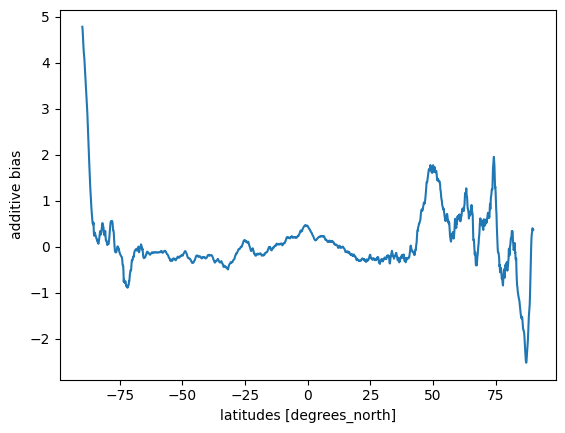

In [3]:
# Calculate additive bias and preserve the "lat" dimension
bias = additive_bias(fcst.temp_scrn, obs.temp_scrn, preserve_dims="lat")
bias.name = "additive bias"
bias.plot()

We can see how biases become larger towards the poles, but are relatively unbiased in the tropics.

### Multiplicative bias

Let's imagine that our data has a lower bound at zero and we want to calculate the multiplicative bias. To avoid downloading more data, we will convert the temperature data to be degrees Celcius and clip the data to have a minimum value of zero. Readers may wish to explore the data available from the NCI server and download a wind grid instead for this example.

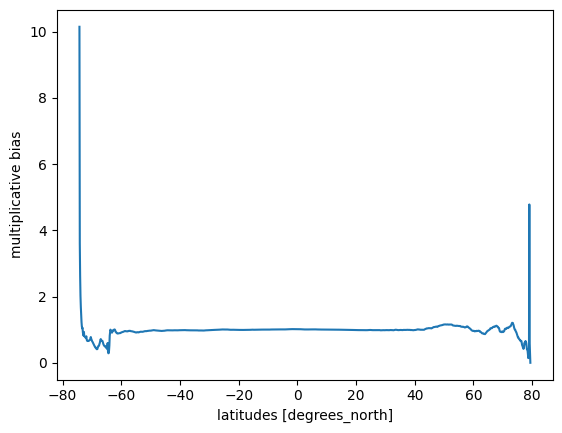

In [4]:
# Convert to Celcius and clip data to have a minimum value of zero
fcst_clipped = (fcst.temp_scrn - 273.15).clip(min=0)
obs_clipped = (obs.temp_scrn - 273.15).clip(min=0)

bias = multiplicative_bias(fcst_clipped, obs_clipped, preserve_dims="lat")
bias.name = "multiplicative bias"
bias.plot()

It's worth noting that for a latitude slice, if the mean forecast and mean observation is zero, then the multiplicative bias for that latitude slice will be `NaN`. If the mean forecast is greater than zero and the mean observation is zero, then the multiplicative bias for that slice is infinite. 

We can see below in our dataset that we have `np.inf` values, and `np.nan` values close to the poles where values are negative (remember that this data is temperature data converted to degrees Celisus and clipped to have a minimum value of zero). 

In [5]:
bias.max()


<xarray.DataArray 'multiplicative bias' ()> Size: 8B
array(inf)

In [6]:
bias

<xarray.DataArray 'multiplicative bias' (lat: 1536)> Size: 6kB
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * lat      (lat) float64 12kB 89.94 89.82 89.71 89.59 ... -89.71 -89.82 -89.94

### Additive bias percentage

Let's imagine that fcst.temp_scrn represents the forecasted flow values and obs.temp_scrn represents the observed flow values. Now, we want to create another dataset with significantly higher values by adding 1000 to both the observed and forecasted flow values.

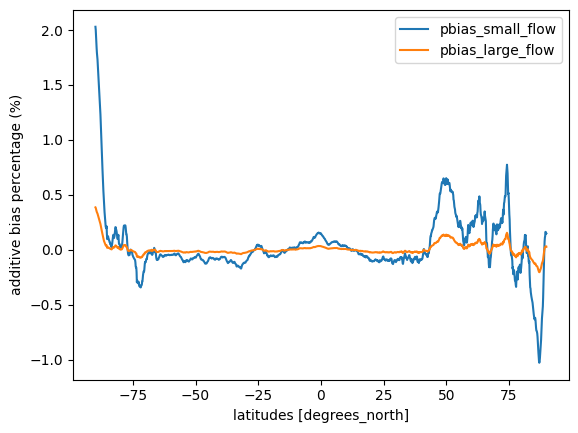

In [7]:
import matplotlib.pyplot as plt
fcst_flow = fcst.temp_scrn
obs_flow = obs.temp_scrn
# Calculate additive bias precentage and preserve the "lat" dimension
pbias = additive_bias_percentage(fcst_flow, obs_flow, preserve_dims="lat")
pbias.name = "additive bias percentage (%)"
# Generate second dataset with large flow values
fcst_flow_large=fcst_flow + 1000
obs_flow_large = obs_flow + 1000
# Calculate additive bias precentage for large flow values and preserve the "lat" dimension
pbias_large_flow = additive_bias_percentage(fcst_flow_large, obs_flow_large, preserve_dims="lat")
pbias_large_flow.name = "additive bias percentage (%)"
# Compare the additive bias precentage for small and large flow values
pbias.plot(label='pbias_small_flow')
pbias_large_flow.plot(label='pbias_large_flow')
plt.legend()
plt.show()

As expected, the additive bias percentage is higher for small forecast and observation values compared to large ones, although the absolute additive bias is the same for both datasets.

## What to try next?
Have a look at Isotonic Regression in scores to see how conditional biases can be calculated.
